**KL divergence** measures the 'difference' between two distributions

In this notebook:

- Create probability distribution of pause lengths in child readings
- Compute the average KL divergence from that distribution to the distributions of pause lengths in gold readings
- Scatterplot this metric against other metrics (e.g. response-level wcpm).

In [1]:
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import spatial
from collections import Counter, defaultdict

In [2]:
better_info_table = pd.read_csv('better_table_for_predicting_rate.csv')

In [3]:
def load_json(path):
    with open('../data/moby/jsons/' + path) as f:
        return json.load(f)
    
child_response_to_words = load_json('child_response_to_words.json')
child_response_to_item = load_json('child_response_to_item.json')
gold_response_to_words = load_json('gold_response_to_words.json')
gold_response_to_item = load_json('gold_response_to_item.json')

In [4]:
ls ../data/moby/jsons/

child_response_to_item.json
child_response_to_session.json
child_response_to_words.json
child_session_to_responses.json
form_to_grade.json
form_to_sessions.json
gold_response_to_item.json
gold_response_to_session.json
gold_response_to_words.json
gold_session_to_responses.json
item_to_form.json
item_to_level_to_constituency_ids.json
item_to_passage.json
item_to_recstring.json
response_to_annotate_category_to_scores.json
response_to_annote_category_to_scores.json
session_to_acc.json
session_to_acc_zscore.json
session_to_acc_zscore_by_grade.json
session_to_annotate_category_to_scores.json
session_to_annote_category_to_scores.json
session_to_difficulty_metrics.json
session_to_form.json
session_to_wcpm.json
session_to_wcpm_zscore.json
session_to_wcpm_zscore_by_grade.json


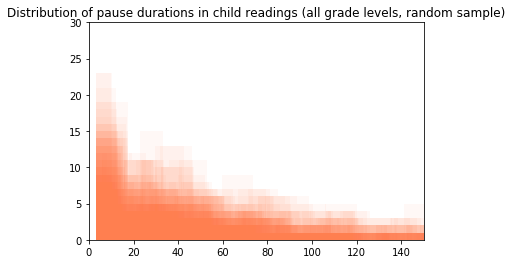

In [5]:
i = 0
plt.title('Distribution of pause durations in child readings (all grade levels, random sample)')
plt.xlim(0, 150)
plt.ylim(0, 30)
for response, words in child_response_to_words.items():
    words_trimmed = [xyz[2] for xyz in words[1:-1] if xyz[0][0] == '<']
    words_trimmed = [x for x in words_trimmed if x < 300]
    if i % 25 == 0:
        plt.hist(words_trimmed, bins=20, alpha=.05, color='coral')
    i += 1

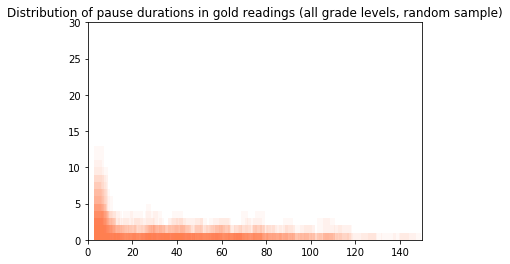

In [6]:
i = 0
plt.title('Distribution of pause durations in gold readings (all grade levels, random sample)')
plt.xlim(0, 150)
plt.ylim(0, 30)
for response, words in gold_response_to_words.items():
    words_trimmed = [xyz[2] for xyz in words[1:-1] if xyz[0][0] == '<']
    words_trimmed = [x for x in words_trimmed if x < 300]
    if i % 3 == 0:
        plt.hist(words_trimmed, bins=20, alpha=.05, color='coral')
    i += 1

In [7]:
BINS = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

def get_frequency_distribution_from_alignment(words):
    pauses = [xyz[-1] for xyz in words]
    binned = Counter(np.digitize(pauses, bins=BINS))
    distrib = [binned[i] for i in range(len(BINS) + 1)]
    distrib = np.array(distrib) / sum(distrib)
    distrib += 0.001
    return distrib

def KL(p, q):
    return sum(p[i] * math.log2(p[i]/q[i]) for i in range(len(p)))

def cosine(p, q):
    return spatial.distance.cosine(p, q)

In [8]:
item_to_gold_pause_distributions = defaultdict(list)
for response, words in gold_response_to_words.items():
    distrib = get_frequency_distribution_from_alignment(words)
    item = gold_response_to_item[response]
    item_to_gold_pause_distributions[item].append(distrib)

In [9]:
def get_score_from_child_alignment(child_response):
    child_response = str(child_response)
    item = child_response_to_item[child_response]
    words = child_response_to_words[child_response]
    response_distrib = get_frequency_distribution_from_alignment(words)
    
    gold_distribs = item_to_gold_pause_distributions[item]
    KLs = [KL(response_distrib, gd) for gd in gold_distribs]
    return np.median(KLs)

def get_cosine_score_from_child_alignment(child_response):
    child_response = str(child_response)
    item = child_response_to_item[child_response]
    words = child_response_to_words[child_response]
    response_distrib = get_frequency_distribution_from_alignment(words)
    
    gold_distribs = item_to_gold_pause_distributions[item]
    cosines = [cosine(response_distrib, gd) for gd in gold_distribs]
    return np.median(cosines)

def get_median_pause_token_length(child_response):
    words = child_response_to_words[str(child_response)]
    words_trimmed = [xyz[2] for xyz in words[1:-1] if xyz[0][0] == '<']
    words_trimmed = [x for x in words_trimmed if x < 100]
    return np.median(words_trimmed)

In [10]:
better_info_table['kl_score'] = better_info_table.response.apply(get_score_from_child_alignment)
better_info_table['cosine_score'] = better_info_table.response.apply(get_cosine_score_from_child_alignment)
better_info_table['median_pause_len'] = better_info_table.response.apply(get_median_pause_token_length)

In [11]:
better_info_table

,response,session,is_perfect,not_too_slow,not_too_fast,item,form,grade,session_wcpm,session_acc,response_wcpm,kl_score,cosine_score,median_pause_len
0,748431,47152,0,1,0,330,Grade2Spring,Grade2,155.0,1.000,151.7,0.263649,0.146021,39.0
1,565127,32210,0,0,1,330,Grade2Spring,Grade2,41.0,0.776,43.0,0.586784,0.336871,24.0
2,760144,48359,0,1,0,330,Grade2Spring,Grade2,134.0,0.992,131.3,0.205746,0.118494,24.0
3,805147,52812,0,0,1,330,Grade2Spring,Grade2,50.0,0.908,34.9,0.473690,0.279468,30.0
4,680973,40865,0,0,1,330,Grade2Spring,Grade2,28.0,0.912,27.6,1.706196,0.558097,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3493,798787,52191,0,0,1,1903,Grade1Fall,Grade1,29.0,0.773,13.3,2.112381,0.707046,60.0
3494,805316,52831,1,1,1,450,Grade3Spring,Grade3,106.0,0.923,105.9,0.234606,0.127403,36.0
3495,501378,27837,1,1,1,2701,Grade3Fall,Grade3,127.0,1.000,124.0,0.232074,0.136208,12.0
3496,536550,30306,1,1,1,2904,Grade4Fall,Grade4,32.0,0.667,27.5,0.514372,0.267047,19.5


In [12]:
def scatterplot(label_name, xname, yname):
    positive_df = better_info_table.loc[better_info_table[label_name] == 1]
    negative_df = better_info_table.loc[better_info_table[label_name] == 0]
    
    plt.figure(figsize=(6, 6))
    plt.title(label_name + ' : ' + xname + ', ' + yname)
    plt.xlabel(xname)
    plt.ylabel(yname)
    
    true_x = positive_df[xname]
    true_y = positive_df[yname]
    plt.scatter(true_x, true_y, label=label_name + '=true', color='green', marker='.', alpha=.15)
    
    false_x = negative_df[xname]
    false_y = negative_df[yname]
    plt.scatter(false_x, false_y, label=label_name + '=false', color='red', marker='x', alpha=.15)
    
    plt.legend()
    plt.show()
    print('true: {}, false: {}, (total = {})'.format(len(true_x), len(false_x), len(true_x) + len(false_x)))

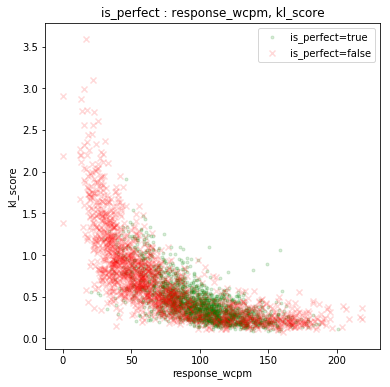

true: 1912, false: 1586, (total = 3498)


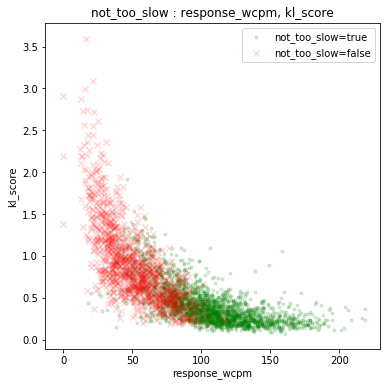

true: 2374, false: 1124, (total = 3498)


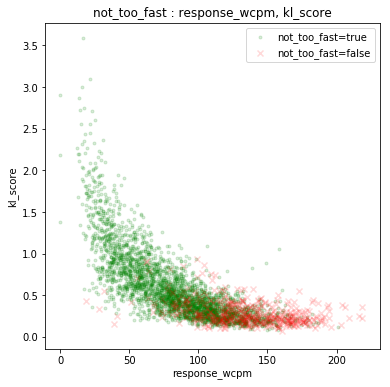

true: 3022, false: 476, (total = 3498)


In [13]:
scatterplot('is_perfect', 'response_wcpm', 'kl_score')
scatterplot('not_too_slow', 'response_wcpm', 'kl_score')
scatterplot('not_too_fast', 'response_wcpm', 'kl_score')

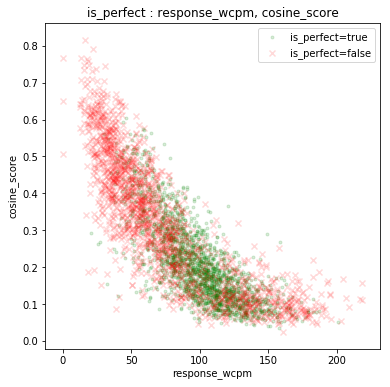

true: 1912, false: 1586, (total = 3498)


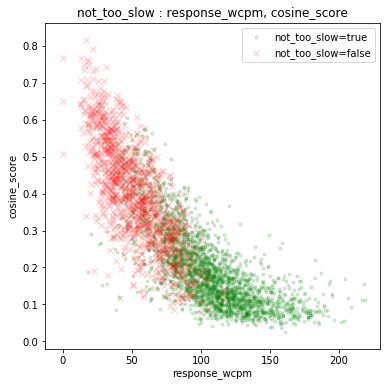

true: 2374, false: 1124, (total = 3498)


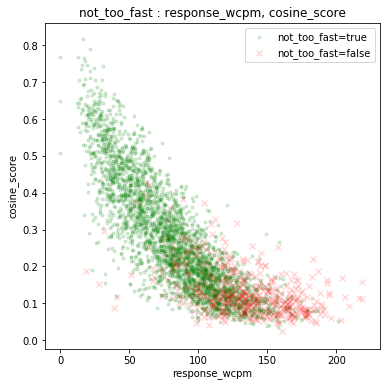

true: 3022, false: 476, (total = 3498)


In [14]:
scatterplot('is_perfect', 'response_wcpm', 'cosine_score')
scatterplot('not_too_slow', 'response_wcpm', 'cosine_score')
scatterplot('not_too_fast', 'response_wcpm', 'cosine_score')

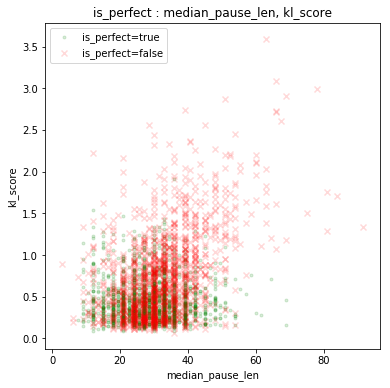

true: 1912, false: 1586, (total = 3498)


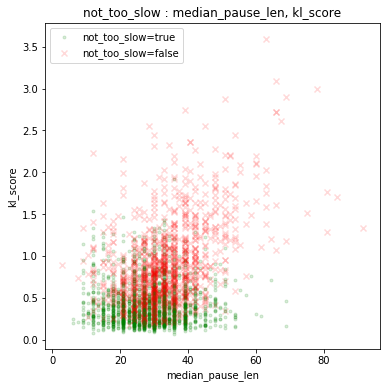

true: 2374, false: 1124, (total = 3498)


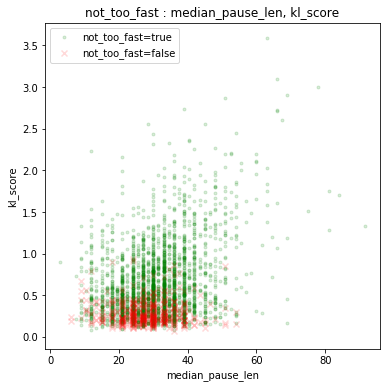

true: 3022, false: 476, (total = 3498)


In [15]:
scatterplot('is_perfect', 'median_pause_len', 'kl_score')
scatterplot('not_too_slow', 'median_pause_len', 'kl_score')
scatterplot('not_too_fast', 'median_pause_len', 'kl_score')

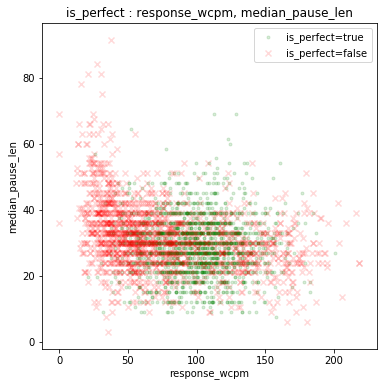

true: 1912, false: 1586, (total = 3498)


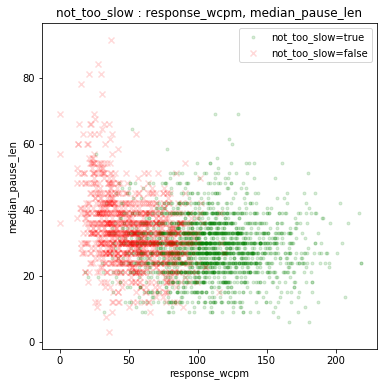

true: 2374, false: 1124, (total = 3498)


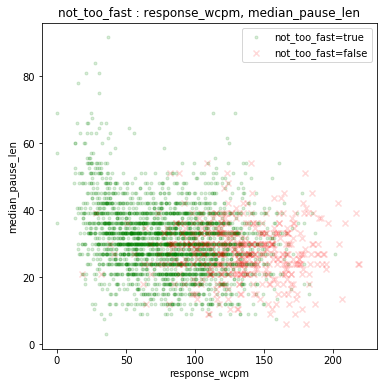

true: 3022, false: 476, (total = 3498)


In [16]:
scatterplot('is_perfect', 'response_wcpm', 'median_pause_len')
scatterplot('not_too_slow', 'response_wcpm', 'median_pause_len')
scatterplot('not_too_fast', 'response_wcpm', 'median_pause_len')

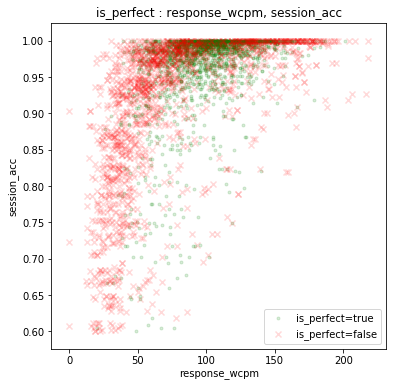

true: 1912, false: 1586, (total = 3498)


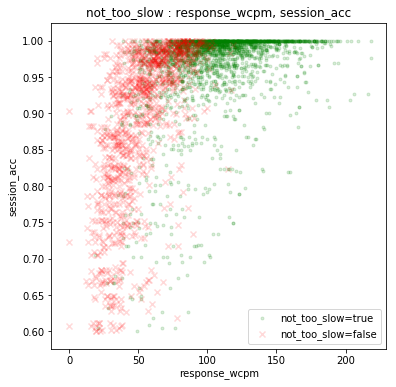

true: 2374, false: 1124, (total = 3498)


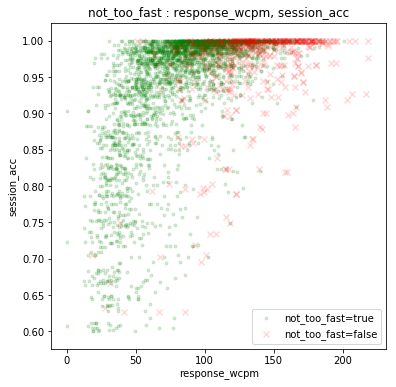

true: 3022, false: 476, (total = 3498)


In [17]:
scatterplot('is_perfect', 'response_wcpm', 'session_acc')
scatterplot('not_too_slow', 'response_wcpm', 'session_acc')
scatterplot('not_too_fast', 'response_wcpm', 'session_acc')